In [1]:
import pandas as pd

In [2]:
df = pd.read_csv("../jigsaw/dataset_text_target.csv")
df_true = df[df.target > 0.5]
df_false = df[df.target <= 0.5]

In [3]:
df_true

,comment_text,target
4,haha you guys are a bunch of losers.,0.893617
5,ur a sh*tty comment.,0.666667
13,It's ridiculous that these guys are being call...,0.600000
31,Yet call out all Muslims for the acts of a few...,0.912500
34,This bitch is nuts. Who would read a book by a...,0.830769
...,...,...
1804786,A sexual predator lives in the White House now...,0.600000
1804825,Who is the jerk in the last row between the C ...,0.833333
1804838,Nobody really cares that she supports the scie...,0.700000
1804857,"I take your point, but I think you're shooting...",0.700000


In [4]:
df = pd.concat([df_true[:500], df_false[:500]], axis=0)

<Axes: >

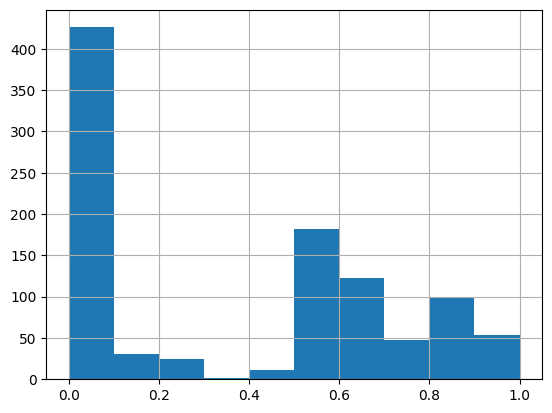

In [5]:
df.target.hist()

In [6]:
mapper = lambda x: 1 if x > 0.5 else 0
df.target = df.target.apply(mapper)

In [7]:
from transformers import BertTokenizer, TFBertForSequenceClassification

/Users/mahas/PycharmProjects/STIRS/.venv/lib/python3.9/site-packages/urllib3/__init__.py:35: NotOpenSSLWarning: urllib3 v2 only supports OpenSSL 1.1.1+, currently the 'ssl' module is compiled with 'LibreSSL 2.8.3'. See: https://github.com/urllib3/urllib3/issues/3020
  warnings.warn(
/Users/mahas/PycharmProjects/STIRS/.venv/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [8]:
from sklearn.model_selection import train_test_split
x_train, x_test, y_train, y_test = train_test_split(df.comment_text, df.target, test_size=0.2, random_state=42, stratify=df.target, shuffle=True)

In [9]:
y_train.value_counts()

target
1    400
0    400
Name: count, dtype: int64

In [10]:
#Tokenize and encode the data using the BERT tokenizer
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased', do_lower_case=True)

In [11]:
max_len = 128

In [12]:
X_train_encoded = tokenizer.batch_encode_plus(
    x_train.tolist(),
    padding='max_length',
    truncation=True,
    max_length=max_len,
    add_special_tokens=True,
    return_tensors='tf'
)
X_test_encoded = tokenizer.batch_encode_plus(
    x_test.tolist(),
    padding='max_length',
    truncation=True,
    max_length=max_len,
    add_special_tokens=True,
    return_tensors='tf'
)

2025-05-10 12:24:47.564884: I metal_plugin/src/device/metal_device.cc:1154] Metal device set to: Apple M3
2025-05-10 12:24:47.564910: I metal_plugin/src/device/metal_device.cc:296] systemMemory: 16.00 GB
2025-05-10 12:24:47.564915: I metal_plugin/src/device/metal_device.cc:313] maxCacheSize: 5.33 GB
I0000 00:00:1746860087.565305 11251985 pluggable_device_factory.cc:305] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
I0000 00:00:1746860087.565549 11251985 pluggable_device_factory.cc:271] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


In [13]:
model = TFBertForSequenceClassification.from_pretrained('bert-base-uncased', num_labels=2)

All PyTorch model weights were used when initializing TFBertForSequenceClassification.

Some weights or buffers of the TF 2.0 model TFBertForSequenceClassification were not initialized from the PyTorch model and are newly initialized: ['classifier.weight', 'classifier.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [14]:
import tensorflow as tf

In [15]:
optimizer = tf.keras.optimizers.Adam(learning_rate=2e-5)
loss = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True)
metric = tf.keras.metrics.SparseCategoricalAccuracy('accuracy')
model.compile(optimizer=optimizer, loss=loss, metrics=[metric])

In [16]:
history = model.fit(
    [X_train_encoded['input_ids'], X_train_encoded['token_type_ids'], X_train_encoded['attention_mask']],
    y_train,
    validation_data=(
        [X_test_encoded['input_ids'], X_test_encoded['token_type_ids'], X_test_encoded['attention_mask']],y_test),
    batch_size=32,
    epochs=5
)

Epoch 1/5


2025-05-10 12:24:55.287363: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:117] Plugin optimizer for device_type GPU is enabled.
E0000 00:00:1746860095.790918 11251985 meta_optimizer.cc:967] model_pruner failed: INVALID_ARGUMENT: Graph does not contain terminal node Adam/AssignAddVariableOp_10.


25/25 [==============================] - 75s 3s/step - loss: 0.6890 - accuracy: 0.5275 - val_loss: 0.6714 - val_accuracy: 0.6150
Epoch 2/5
25/25 [==============================] - 133s 5s/step - loss: 0.6094 - accuracy: 0.7025 - val_loss: 0.6165 - val_accuracy: 0.6650
Epoch 3/5
25/25 [==============================] - 150s 6s/step - loss: 0.4315 - accuracy: 0.8225 - val_loss: 0.4069 - val_accuracy: 0.8100
Epoch 4/5
25/25 [==============================] - 152s 6s/step - loss: 0.2346 - accuracy: 0.9262 - val_loss: 0.3492 - val_accuracy: 0.8700
Epoch 5/5
25/25 [==============================] - 124s 5s/step - loss: 0.1104 - accuracy: 0.9688 - val_loss: 0.4099 - val_accuracy: 0.8550


In [17]:
y_test.value_counts()

target
1    100
0    100
Name: count, dtype: int64

In [18]:
from sklearn.metrics import classification_report

In [19]:
y_pred = model.predict(
    [X_test_encoded['input_ids'], X_test_encoded['token_type_ids'], X_test_encoded['attention_mask']])
y_pred = tf.argmax(y_pred.logits, axis=1).numpy()


7/7 [==============================] - 15s 2s/step


In [20]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.92      0.78      0.84       100
           1       0.81      0.93      0.87       100

    accuracy                           0.85       200
   macro avg       0.86      0.85      0.85       200
weighted avg       0.86      0.85      0.85       200



In [21]:
model.save_pretrained("bert_model_trained")